In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Graph SLAM Problem

$\min J(x_i) = x_0^T\Omega_0 x_0 + \sum_t e_t R_t^{-1} e_t  + \sum_t \sum_i \tilde{z}^i_t  Q_t^{-1} \tilde{z}^i_t \$

$ e_t \equiv x_t - g(u_t, x_{t-1})$ prediction error at time t

$\tilde{z}^i_t \equiv z^i_t - h(x_t, m^i_t)$ measurement error

$\dot{p_x} = v_x$

$\dot{p_y} = v_y$

$x_t = \begin{bmatrix} p_x \\ p_y \end{bmatrix}$
$u_t = \begin{bmatrix} v_x \\ v_y \end{bmatrix}$

$x_t = x_{t-1} + \Delta_t u_t $

$g(u_t, x_t{-1}) = x_{t-1}  + \Delta_t u_t$

Landmarks are points. And our measurement is relative position.

In [119]:
def g(x: np.array, u: np.array, dt: float):
    """
    Vehicle dynamics propagation.
    
    @param x: vehicle state
    @param u: vehicle input
    @param dt: time step
    """
    return x + u*dt

def data_association(x: np.array, z: np.array, landmarks: np.array):
    """
    Associates measurement with known landmarks using maximum likelihood
    
    @param x: state of vehicle
    @param z: measurement
    @param landmarks: map of known landmarks
    """
    z_expected = landmarks - x
    z_error = z - z_expected
    dist = np.linalg.norm(z_error, axis=1)
    i = np.argmin(dist)
    return i

def h(x, m, noise=None):
    """
    Predicts the measurements of a landmark at a given state. Returns None 
    if out of range.
    
    @param x: vehicle static
    @param m: landmark
    @param noise: bool to control noise
    """
    dm = m - x
    d = np.linalg.norm(dm)
    m_range = d
    m_bearing = np.arctan2(dm[0], dm[1])
    if noise is not None:
        m_bearing += noise['bearing_std']*np.random.randn()
        m_range += d*noise['range_std']*np.random.randn()
    return [m_range, m_bearing]

def measure_landmarks(x, landmarks, noise=None, range_max=4):
    """
    Predicts all measurements at a given state
    
    @param x: vehicle static
    @param landmarks: list of existing landmarks
    @param noise: bool to control noise
    """
    z_list = []
    for m in landmarks:
        z = h(x, m, noise=noise)
        if z[0] < range_max:
            z_list.append(z)
    return z_list

def measure_odom(x, x_prev, noise=None):
    dx = x - x_prev
    d = np.linalg.norm(dx)
    theta = np.arctan2(dx[0], dx[1])
    R = np.array([[np.cos(theta), -np.sin(theta)], [np.cos(theta), np.sin(theta)]])
    odom = dx
    if noise is not None:
        odom += d*(noise['odom_std']*np.random.randn(2) + R@np.array([noise['odom_bx_bias'], noise['odom_by_bias']]))
    return list(odom)

In [120]:
def simulate(noise=None):
    x = np.array([0, 0])
    x_prev = x
    u = np.array([1, 1])
    dt = 2

    landmarks = np.array([
        [1, 3],
        [4, 6],
        [9, 1]
    ])

    hist = {
        'x': [],
        'u': [],
        'odom': [],
        'meas': []
    }

    for i in range(10):
        t = dt*i

        # measure landmarks
        z_list = measure_landmarks(x, landmarks, noise=noise)

        # propagate
        u = np.array([np.sin(t/10), np.cos(t/10)])
        x = g(x_prev, u, dt) # predict

        # odometry
        odom = measure_odom(x, x_prev, noise=noise)

        x_prev = x

        hist['x'].append(x)
        hist['u'].append(u)
        hist['odom'].append(odom)
        hist['meas'].append(z_list)

    for key in ['x', 'u']:
        hist[key] = np.array(hist[key])

    fig = plt.figure(1)
    plt.plot(landmarks[:, 0], landmarks[:, 1], 'bo', label='landmarks')
    plt.plot(hist['x'][:, 0], hist['x'][:, 1], 'r.', label='states', markersize=10)

    # plot odom
    x_odom = np.array([0, 0], dtype=float)
    x_odom_hist = [x_odom]
    for odom in hist['odom']:
        x_odom = np.array(x_odom) + np.array(odom)
        x_odom_hist.append(x_odom)
    x_odom_hist = np.array(x_odom_hist)
    plt.plot(x_odom_hist[:, 0], x_odom_hist[:, 1], 'g.', linewidth=3, label='odom')

    # plot measurements
    for x, meas_list in zip(x_odom_hist, hist['meas']):
        for rng, bearing in meas_list:
            plt.arrow(x[0], x[1], rng*np.sin(bearing) , rng*np.cos(bearing), width=0.1,
                          length_includes_head=True)

    plt.axis([0, 10, 0, 10])
    plt.grid()
    plt.legend()
    plt.axis('equal');
    
    return locals()

In [145]:
def J_graph_slam(hist, x_graph, landmarks):
    J = 0
    
    Q = np.eye(2)  # meas covariance
    R = np.eye(2)  # odom covariance
    R_I = np.linalg.inv(R)
    Q_I = np.linalg.inv(Q)
    
    n_x = len(hist['x'])

    for i in range(n_x):
        
        # compute odom cost
        u = hist['u'][i]
        odom = hist['odom'][i]
        odom_predicted = np.array(x_graph[i+1]) - np.array(x_graph[i])
        e_x = np.array(odom) - np.array(odom_predicted)
        J += e_x.T@R_I@e_x
    
        # compute measurement cost
        meas_list = hist['meas'][i]
        n_m = len(meas_list)
        z_i = measure_landmarks(x_graph[i], landmarks)
        for j in range(n_m):
            z_ij = meas_list[j]
            c_ij = data_association(x_graph[i], z_ij, landmarks)
            z_ij_predicted = h(x_graph[i], landmarks[c_ij])
            e_z = np.array(z_ij) - np.array(z_ij_predicted)
            print(i, j, e_z)
            J += e_z.T@Q_I@e_z
    return J

0 0 [0. 0.]
1 0 [0. 0.]
2 0 [-3.00647227  1.52547254]
3 0 [0. 0.]
3 1 [0. 0.]
4 0 [0. 0.]
5 0 [0. 0.]


11.365941995027006

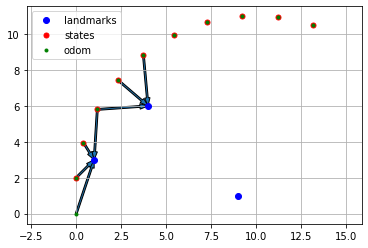

In [146]:
noise={
    'odom_std': 0,
    'bearing_std': 0,
    'range_std': 0,
    'odom_bx_bias': 0,
    'odom_by_bias': 0
}
sim = simulate(noise=noise);
J_graph_slam(sim['hist'], sim['x_odom_hist'], sim['landmarks'])